In [1]:
import yfinance as yf
import math
from time import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [2]:
def plot_2D_lines(pred,real, dates):
    plt.plot(dates, pred, label="Predicted prices")
    plt.plot(dates, real, label="Actual prices")
    plt.ylabel("Price (USD)")
    plt.title("Regression Predictions")
    plt.legend()
    plt.savefig("predictions.eps", format="eps")
    plt.show()

In [3]:
def plot_cost(data, dates):
    plt.plot(dates, data, linewidth=0.3)
    plt.ylabel("Square Magnitude of Prediction Error")
    plt.title("Error Curve")
    plt.savefig("cost.eps", format="eps")
    plt.show()

In [4]:
# Retrieve data and save dataframe
stock = yf.Ticker('IBM')
df = stock.history(period='max')
df.to_pickle('IBM_full_history_dataframe')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14917 entries, 1962-01-02 to 2021-04-06
Data columns (total 7 columns):
Open            14917 non-null float64
High            14917 non-null float64
Low             14917 non-null float64
Close           14917 non-null float64
Volume          14917 non-null int64
Dividends       14917 non-null float64
Stock Splits    14917 non-null float64
dtypes: float64(6), int64(1)
memory usage: 932.3 KB


In [5]:
df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02,1.879359,1.879359,1.858243,1.858243,390000,0.0,0.0
1962-01-03,1.858241,1.874485,1.858241,1.874485,292500,0.0,0.0
1962-01-04,1.874484,1.874484,1.854992,1.855805,262500,0.0,0.0
1962-01-05,1.853368,1.853368,1.816008,1.819257,367500,0.0,0.0
1962-01-08,1.817635,1.817635,1.770529,1.785148,547500,0.0,0.0
1962-01-09,1.793268,1.829004,1.793268,1.806263,495000,0.0,0.0
1962-01-10,1.809514,1.817635,1.809514,1.809514,300000,0.0,0.0
1962-01-11,1.814385,1.829004,1.814385,1.829004,322500,0.0,0.0
1962-01-12,1.832253,1.845248,1.832253,1.832253,442500,0.0,0.0


In [6]:
# Divide the dataset into training and testing subsets, set random state for repeatability
train_df, test_df = model_selection.train_test_split(df, test_size=0.3, train_size=0.7, random_state=123, shuffle=True)
X_train_df, y_train_df = train_df[['Open','High','Low','Volume','Dividends','Stock Splits']], train_df[['Close']]
X_train, y_train = X_train_df.iloc[:,:].values, y_train_df.iloc[:].values

X_test_df, y_test_df = test_df[['Open','High','Low','Volume','Dividends','Stock Splits']], test_df[['Close']]
X_test, y_test = X_test_df.iloc[:,:].values, y_test_df.iloc[:].values

In [7]:
# Obtain the in order date index from the shuffled dates
shuffled_dates = list(map(lambda x: x.date(), test_df.index))
true_dates = np.sort(shuffled_dates)

In [8]:
# Obtain dataset parameters
N_SAMPLES = df.count()[0]
N_TRAIN = np.shape(X_train)[0]
N_TEST = np.shape(X_test)[0]

In [9]:
# Collapse 2-D arrays into 1 dimension
y_train = y_train.flatten()
y_test = y_test.flatten()

In [10]:
# Train the model with the training data and labels, predict on test data
model = RandomForestRegressor(n_estimators=100, bootstrap=True, min_samples_leaf=30)
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [11]:
# Sort shuffled data by date
sorted_predictions = sorted(list(zip(shuffled_dates, predictions)), key=lambda x: x[0])
sorted_actuals = sorted(list(zip(shuffled_dates, y_test)), key=lambda x: x[0])

In [12]:
# Extract predictions and labelled values from shuffled data
pred_list = list(zip(*sorted_predictions))
actual_list = list(zip(*sorted_actuals))
date_array = np.array(pred_list[0][:])
pred_array = np.array(pred_list[1][:])
actual_array = np.array(actual_list[1][:])

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


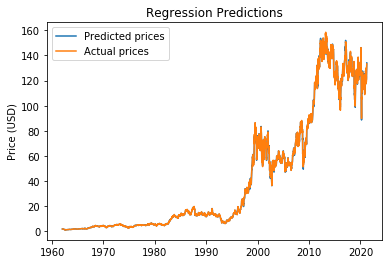

In [13]:
plot_2D_lines(pred_array, actual_array, date_array)

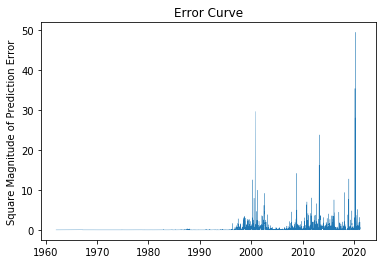

In [14]:
# Obtain cost curve
cost = [abs(i-j)**2 for i,j in zip(pred_array, actual_array)]
plot_cost(cost, date_array)

In [15]:
# Obtain prediction for 25/03/2021
data = np.array([130.33, 133.24, 129.77, 5554000, 0, 0])
data = data.reshape(1,-1)
result = model.predict(data)
print(result)

[131.69619424]


In [16]:
prevThirtyDays = df.tail(30)
prevPrices = prevThirtyDays["Close"].values
variance = np.var(prevPrices)
std_dev = variance ** 0.5
std_dev

5.265917660046919

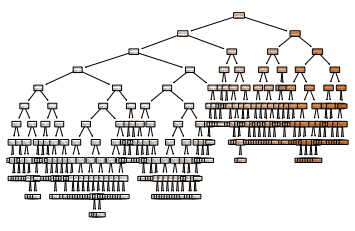

In [17]:
# Plot decision tree
from sklearn import tree

fig = tree.plot_tree(model.estimators_[0], feature_names=list(df), rounded=True, filled=True)